<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2022/blob/main/notebooks/05a_CNN_for_sequences_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Runtime -> Change runtime type -> GPU

In [1]:
!pip install datasets --quiet

     |████████████████████████████████| 365 kB 8.0 MB/s 
     |████████████████████████████████| 212 kB 68.8 MB/s 
     |████████████████████████████████| 120 kB 70.9 MB/s 
     |████████████████████████████████| 115 kB 72.3 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 


# HF Dset

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("simecek/human_nontata_promoters", split="train")

Downloading:   0%|          | 0.00/770 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/simecek___parquet/simecek--human_nontata_promoters-5bc25970767ab8f4/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [3]:
train_dataset 

Dataset({
    features: ['labels', 'seq'],
    num_rows: 27097
})

In [6]:
sample = train_dataset[0]
sample

{'labels': 0,
 'seq': 'ACAGATTCAGGATGTCCTGTCGGGGCATGGACCCTGGAAAGCTGCGGACACCAGGAGGGCAGGCAAGAGAGTCTCATCTCTTGCTCCCTAGGAGCTATGAGTTGAGGGCGCCGTCTGAGCAGGAGGGACGGACGGGTGCCCAGGGTTTGAGGAAAGAGGGGTGTGGGAAGGACGCATGCTAGAACTTCAGAGCAGTTCAGCAGGTGCAGAATGGGAGTTATCATGGGGACTGTGGGAGAAGGGGCGGTGGG'}

In [10]:
from torch.utils.data import DataLoader
nucleotide_to_number = {
    'A':0,
    'C':1,
    'T':2,
    'G':3,
    'N':4,
}

def numericalize(x, vocab):
  x = [vocab[s] for s in x]
  return x

numericalized_x = numericalize(sample['seq'], vocab=nucleotide_to_number)
print(numericalized_x)

[0, 1, 0, 3, 0, 2, 2, 1, 0, 3, 3, 0, 2, 3, 2, 1, 1, 2, 3, 2, 1, 3, 3, 3, 3, 1, 0, 2, 3, 3, 0, 1, 1, 1, 2, 3, 3, 0, 0, 0, 3, 1, 2, 3, 1, 3, 3, 0, 1, 0, 1, 1, 0, 3, 3, 0, 3, 3, 3, 1, 0, 3, 3, 1, 0, 0, 3, 0, 3, 0, 3, 2, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 3, 1, 2, 1, 1, 1, 2, 0, 3, 3, 0, 3, 1, 2, 0, 2, 3, 0, 3, 2, 2, 3, 0, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2, 3, 0, 3, 1, 0, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3, 0, 1, 3, 3, 3, 2, 3, 1, 1, 1, 0, 3, 3, 3, 2, 2, 2, 3, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 0, 0, 3, 3, 0, 1, 3, 1, 0, 2, 3, 1, 2, 0, 3, 0, 0, 1, 2, 2, 1, 0, 3, 0, 3, 1, 0, 3, 2, 2, 1, 0, 3, 1, 0, 3, 3, 2, 3, 1, 0, 3, 0, 0, 2, 3, 3, 3, 0, 3, 2, 2, 0, 2, 1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 3, 2, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3]


In [49]:
import torch
from torch.nn import functional as F
def ohe(x, number_of_classes):
  x = torch.LongTensor(x)
  x = F.one_hot(x, num_classes=number_of_classes)
  x = x.transpose(0,1)
  return x.float()

ohe_x = ohe(numericalized_x, number_of_classes=5)
ohe_x = ohe_x[:,:10]
ohe_x

tensor([[1., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
sample['seq'][:10]

'ACAGATTCAG'

# Convolutional networks

Sequences are one-hot-encoded

Each dimension can be seen as a feature. First row == How much of a feature A is there in that position?

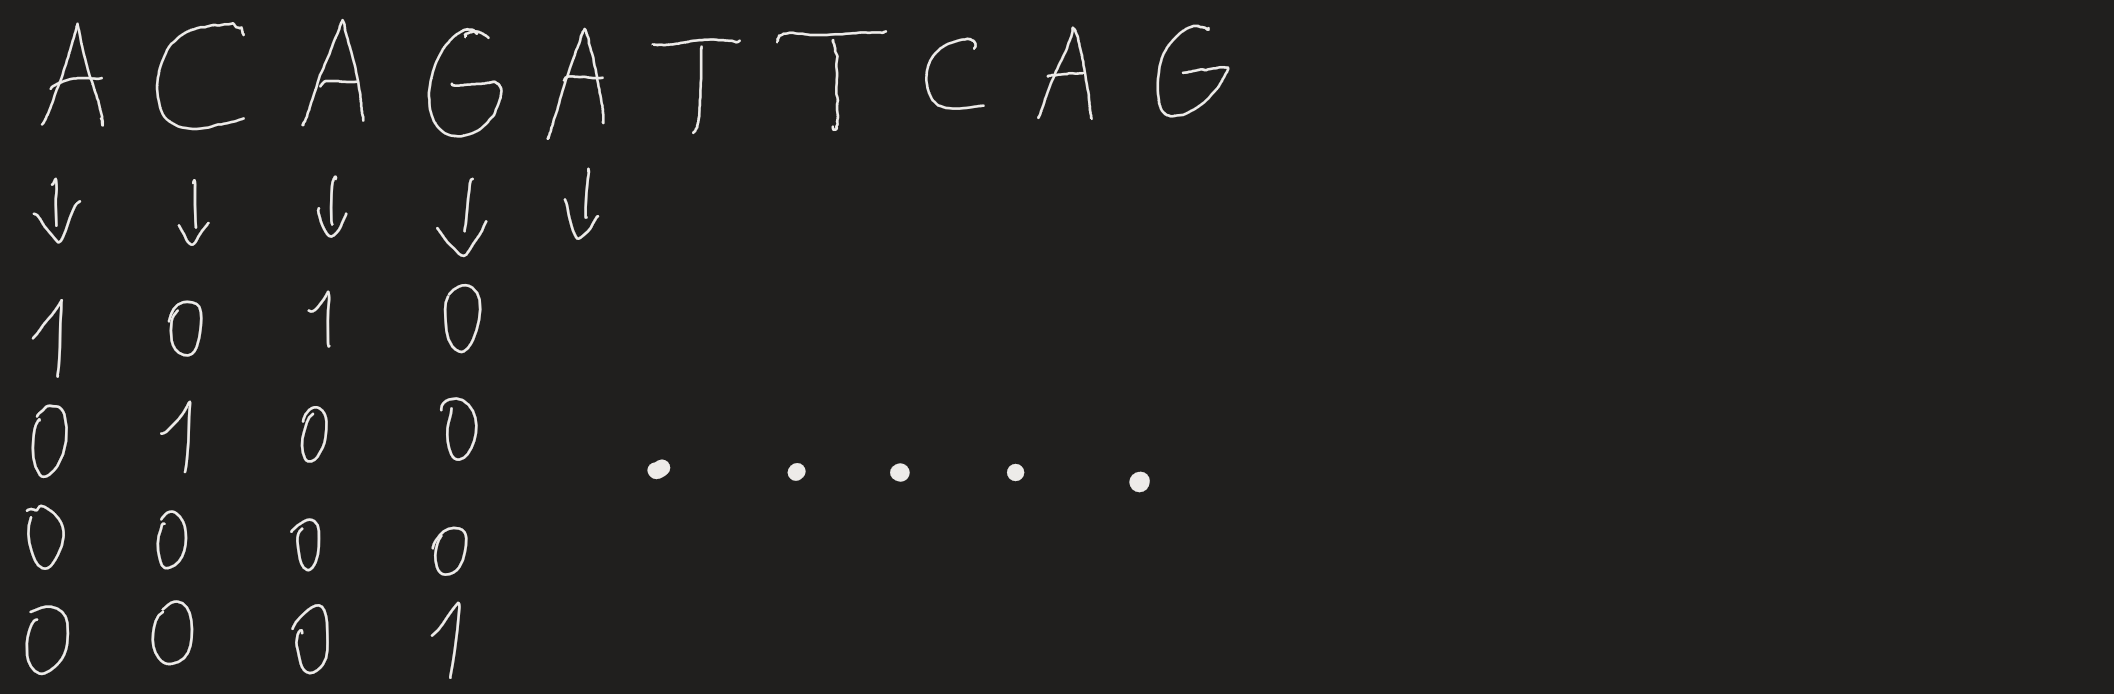

In [40]:
ohe_x

tensor([[1., 0., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Now we have our DATA ready.

We are missing a MODEL, OBJECTIVE, and OPTIMIZER.

Lets start with our MODEL.

# Model (Convolutional neural network - CNN)
Convolution is looking for a specific pattern in data.

The thing looking for a pattern is called a filter.

Its goes through the sequence and outputs new feature - similar to a row in one-hot-encoding. It doesnt have to be just 1 or 0.

Feature map == how much of that feature is there in different positions.

Feature map is shorter than the input

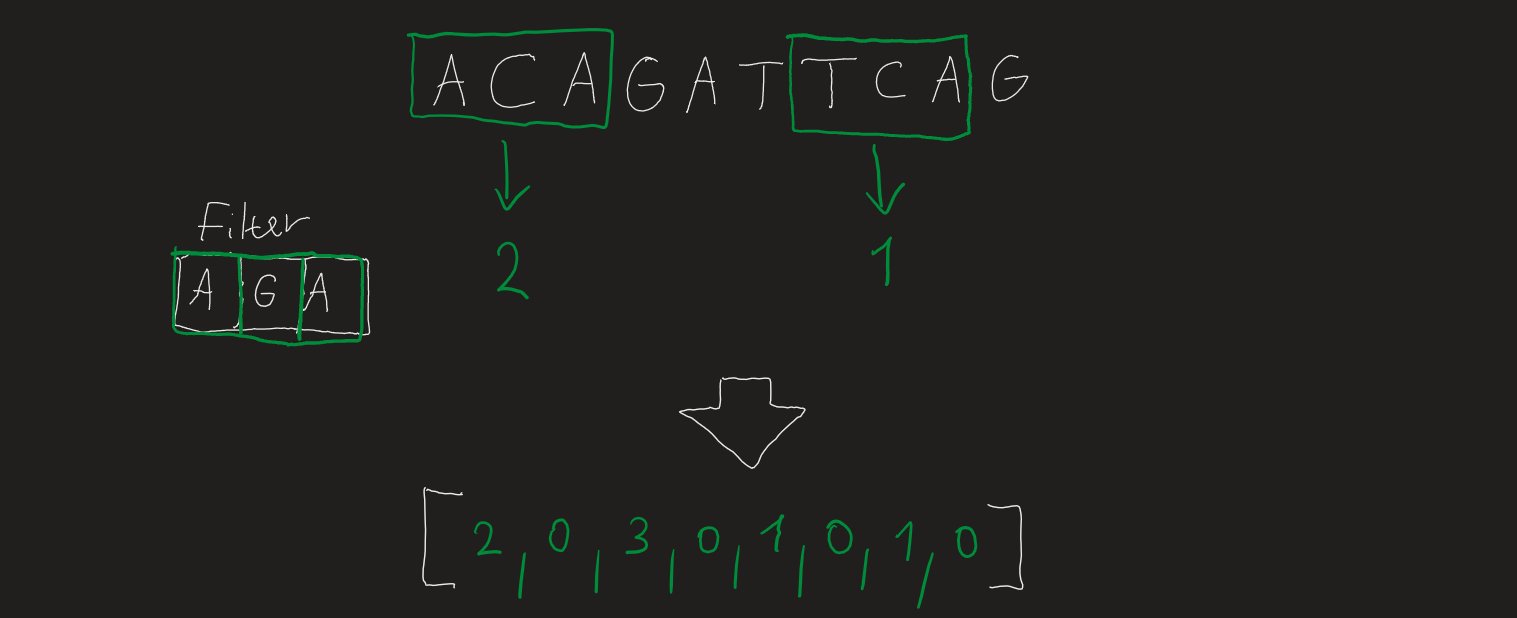

This filter is what neural network learns in a convolutional layer - what pattern to look for, so it can output a feature map of some relevant feature.

We dont have to stop at 1 filter. We can give the network the opportunity to learn multiple filters.

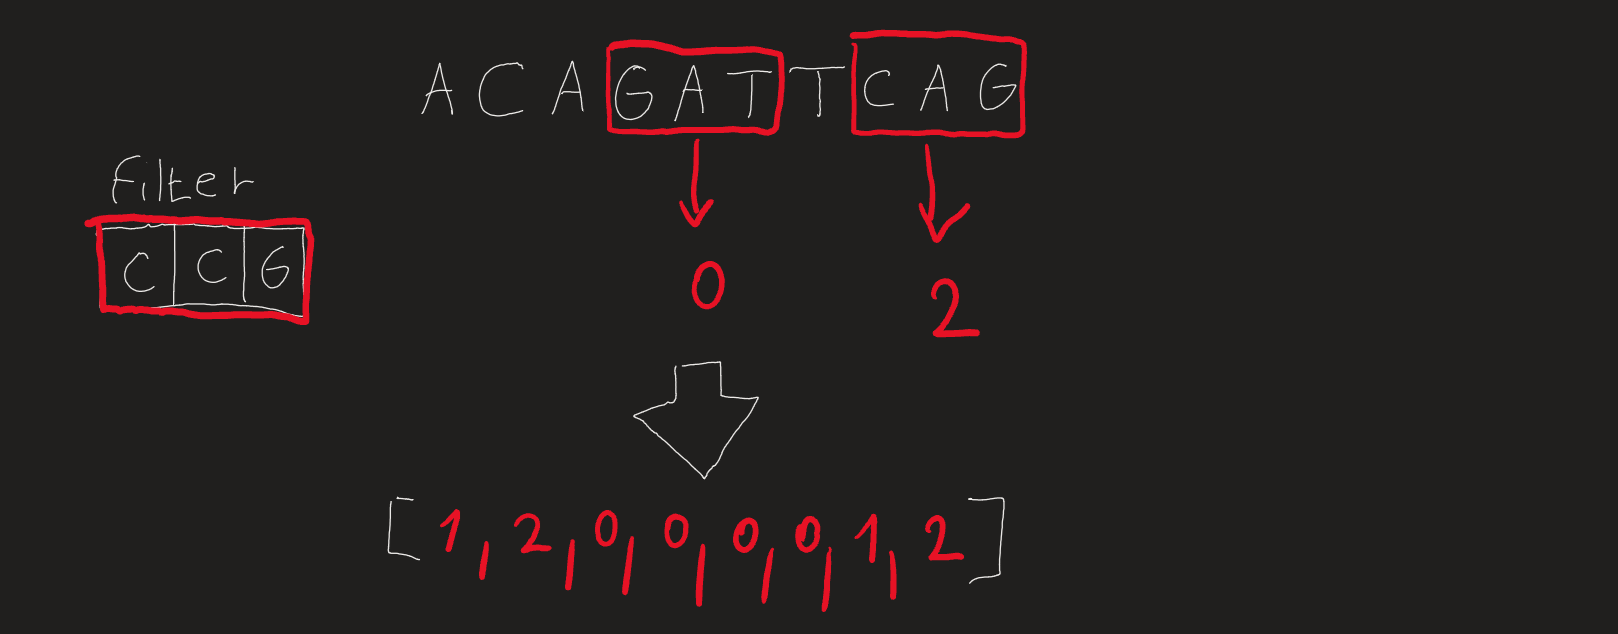

The filter size is called 'kernel size' and its shift along the sequence is called a 'stride'

Using for example 4 filters, will result in 4 feature maps. We can also call them channels.

Notice all of them are shorter, because convolution makes the sequence shorter.

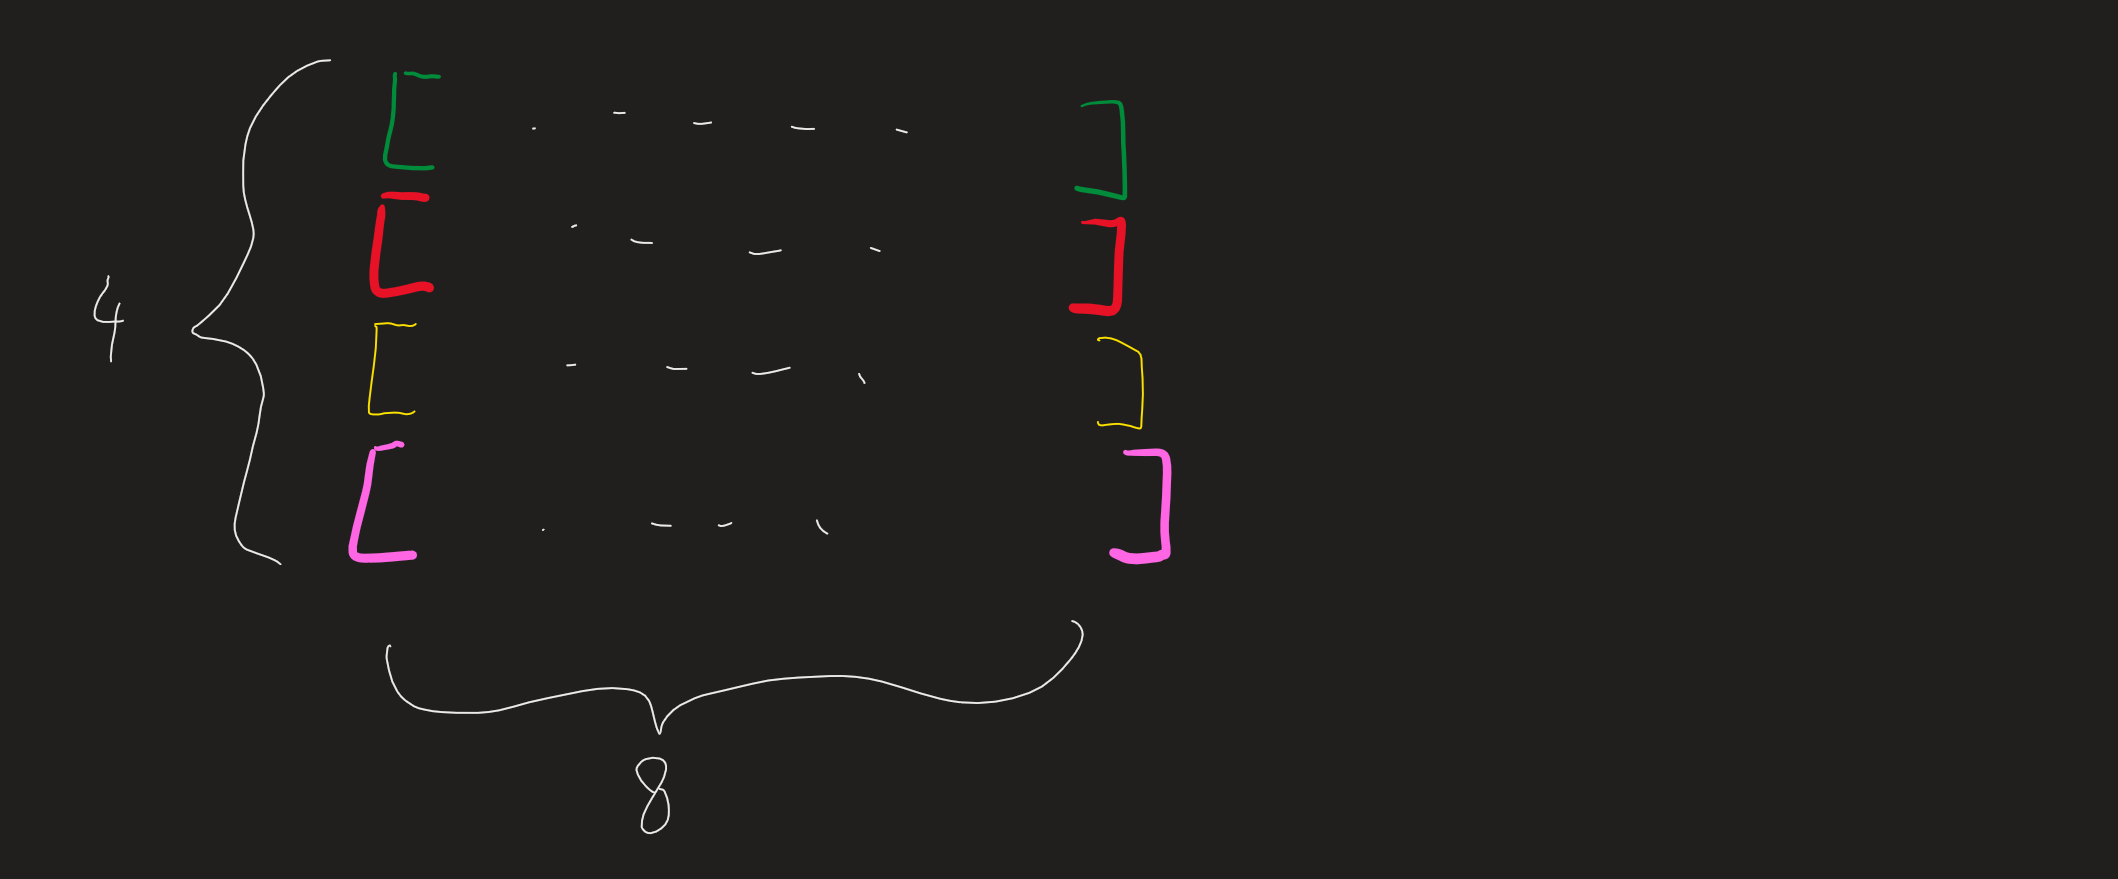

In [41]:
from torch import nn
conv_layer = nn.Conv1d(in_channels=5, out_channels=6, kernel_size=3, stride=1) #At first, filters are random
conv_output = conv_layer(ohe_x)
print(conv_output)
print(conv_output.size())

tensor([[-0.3095, -0.5184, -0.6837, -0.4110, -0.2480, -0.3098, -0.2422, -0.5184],
        [ 0.1038, -0.3355,  0.0941, -0.7325, -0.1669, -0.0679,  0.0326, -0.3355],
        [-0.3448,  0.4677, -0.3465,  0.5122, -0.0046, -0.0576, -0.4112,  0.4677],
        [-0.1417, -0.0420, -0.0868, -0.3920, -0.2669, -0.2855, -0.1210, -0.0420],
        [ 0.0562, -0.0892,  0.0813, -0.4479,  0.1857, -0.3571, -0.1778, -0.0892],
        [-0.1344, -0.2927, -0.3770, -0.3601, -0.4379, -0.2619, -0.3845, -0.2927]],
       grad_fn=<SqueezeBackward1>)
torch.Size([6, 8])


These feature maps need to be 'activated' by an activation function, to allow for non-linear combinations in the next layer. This doesnt change the dimensions, only the values.

ReLU activation is setting all negative numbers to 0. Simple, but non-linear!

In [42]:
activation = nn.ReLU()
activated_conv_output = activation(conv_output)
activated_conv_output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1038, 0.0000, 0.0941, 0.0000, 0.0000, 0.0000, 0.0326, 0.0000],
        [0.0000, 0.4677, 0.0000, 0.5122, 0.0000, 0.0000, 0.0000, 0.4677],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0562, 0.0000, 0.0813, 0.0000, 0.1857, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

To make a class prediction from these activated feature maps, we need to do couple things.

First of all, we need to condense them into a single vector with a flatten layer. This just spreads the feature maps into a single long vector.

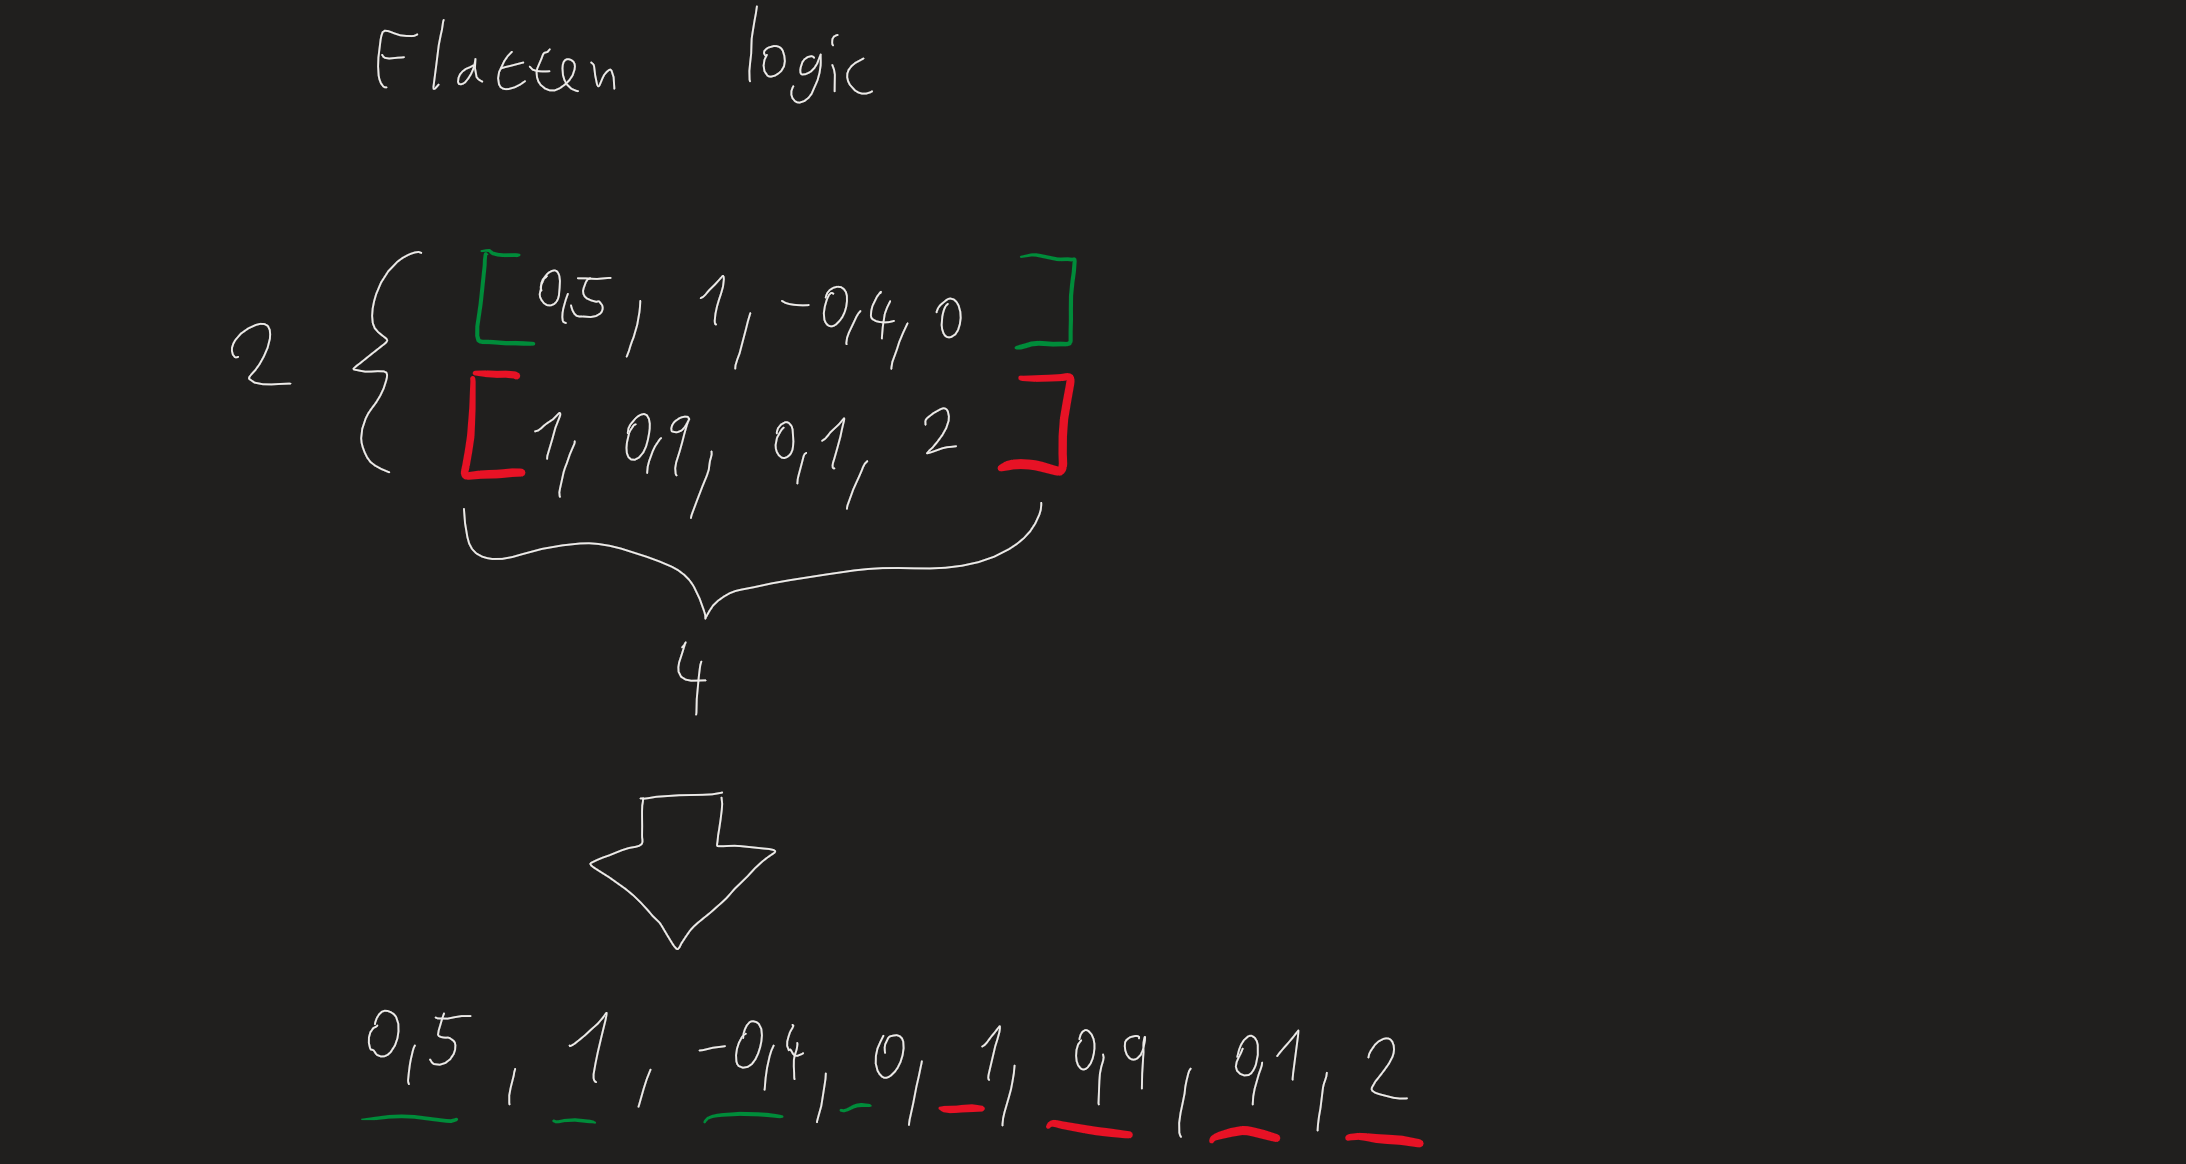

In [43]:
flattening_layer = nn.Flatten(start_dim=0) #start_dim = 0 only needed if applied to a single example, not necessary for batches
flattened = flattening_layer(activated_conv_output) 
print(flattened)
print(flattened.size())

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1038,
        0.0000, 0.0941, 0.0000, 0.0000, 0.0000, 0.0326, 0.0000, 0.0000, 0.4677,
        0.0000, 0.5122, 0.0000, 0.0000, 0.0000, 0.4677, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0562, 0.0000, 0.0813, 0.0000,
        0.1857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], grad_fn=<ReshapeAliasBackward0>)
torch.Size([48])


After we have our 1D vector, we can connect it as a dense layer to our output. 

The output will be able to look into each of these features and positions and make a decision which ones are the important ones to calculate the score.

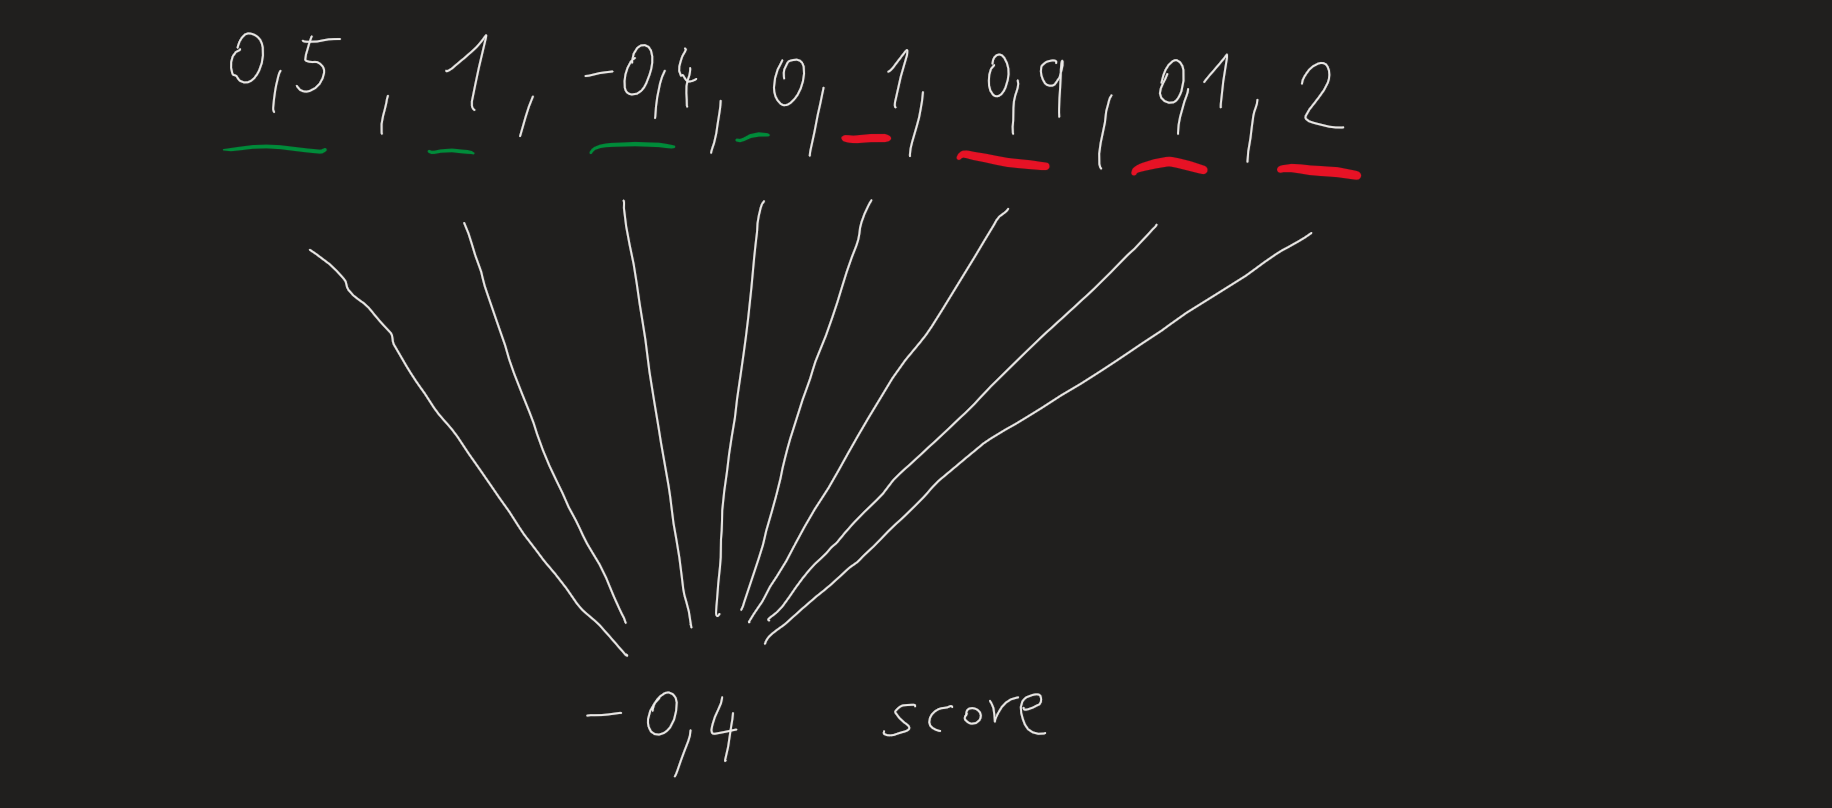

In [44]:
dense_layer = nn.Linear(in_features=48, out_features=1) #At first, the weights for different features are random
clf_score = dense_layer(flattened)
clf_score

tensor([-0.1081], grad_fn=<AddBackward0>)

The score is great, but what we would love to see is a probability. 

We can apply a sigmoid function, which will take any number, and squish it between 0 and 1.

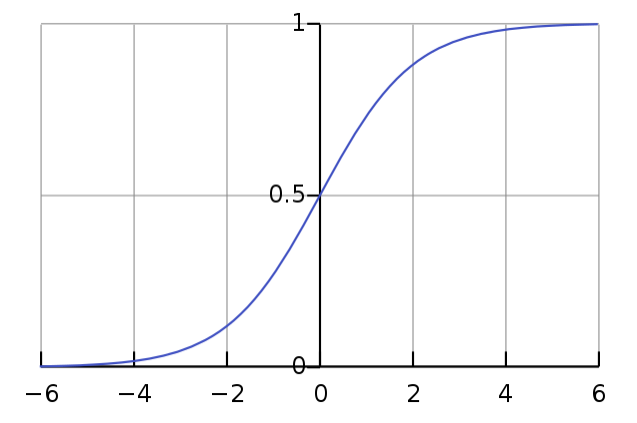

In [45]:
sigmoid = nn.Sigmoid()
probabilities = sigmoid(clf_score)
probabilities

tensor([0.4730], grad_fn=<SigmoidBackward0>)

Perfect! Now we can connect all these pieces into one neural network. It will take One-hot-encoded sequence as an input, and output the probability of the positive class.

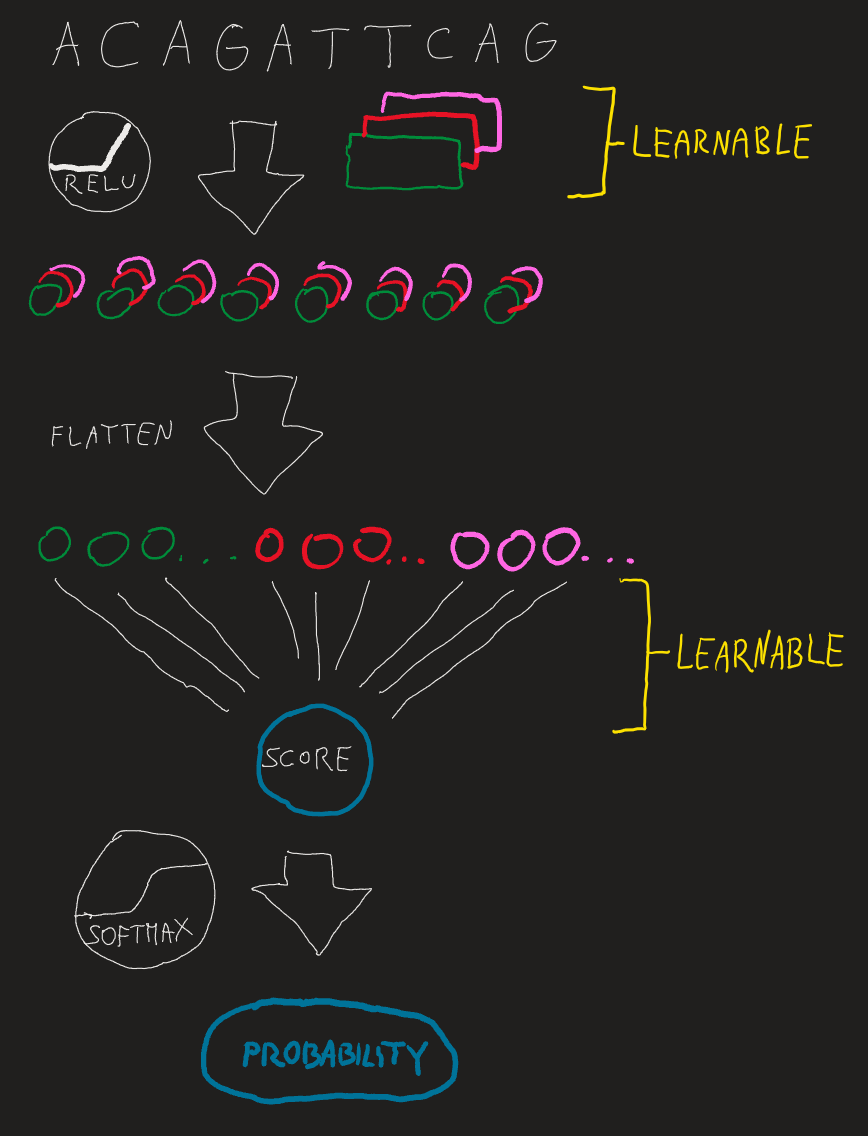

In [62]:
net = nn.Sequential(
    nn.Conv1d(in_channels=5, out_channels=8, kernel_size=5, stride=1),
    nn.ReLU(),
    nn.Flatten(start_dim=0),
    nn.Linear(in_features=48, out_features=1),
    nn.Sigmoid(),
)
probability = net(ohe_x)
probability

tensor([0.5263], grad_fn=<SigmoidBackward0>)

# Exercise

In [48]:
protein_sample = {
    'seq':'HTWRRWEMKYPRARPIHPFKMCNGECKMGT', #30 aminoacids-long protein sequence
    'labels':1
}

amino_to_number = {
  'A': 0,
  'C': 1,
  'D': 2,
  'E': 3,
  'F': 4,
  'G': 5,
  'H': 6,
  'I': 7,
  'K': 8,
  'L': 9,
  'M': 10,
  'N': 11,
  'P': 12,
  'Q': 13,
  'R': 14,
  'S': 15,
  'T': 16,
  'V': 17,
  'W': 18,
  'Y': 19,
}

numericalized_protein = numericalize(protein_sample['seq'], vocab=amino_to_number)
ohe_protein = ohe(numericalized_protein, number_of_classes=20)
ohe_protein

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

In [52]:
protein_net = nn.Sequential(
    #YOUR PART - add convolutional layer
    nn.ReLU(),
    nn.Flatten(start_dim=0),
    nn.LazyLinear(out_features=1),
    nn.Sigmoid(),
)

protein_net(ohe_protein)

tensor([0.4935], grad_fn=<SigmoidBackward0>)

Now we have our DATA and our MODEL

We are missing OBJECTIVE and OPTIMIZER - the learning parts of deep learning

Lets setup our OBJECTIVE.

# Objective

For the model to improve, we need to tell it when it's doing good, and when it's doing bad.

For this we need the true probability of our class and compare it to the probability that our model gave us.

In [59]:
from torch.nn import functional as F
label = sample['labels']
label = torch.FloatTensor([label])
label


tensor([0.])

In [64]:
probability = net(ohe_x)
probability

tensor([0.5263], grad_fn=<SigmoidBackward0>)

To calculate the objective we use a LOSS function. 

The lower the loss, the better the model is doing.

We could just take the distance from the correct label, but we want to punish bigger mistakes more than smaller mistakes. 

Cross-entropy does this.

In [65]:
loss = F.binary_cross_entropy(probability, label)
loss

tensor(0.7472, grad_fn=<BinaryCrossEntropyBackward0>)

Now we have our DATA, MODEL and OBJETCIVE.

The only thing missing is an OPTIMIZER.



# Optimizer

OPTIMIZER takes care of adjusting the MODEL weights so that the OBJECTIVE is better on our DATA.

In [66]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)

SGD (Stochastic gradiend descent) looks at which direction we need to change each of the weights, to make our objective better. 

This magic part is done through backpropagation (derivation, chain rule)

Once we know which way to go, we need to decide how big of a step to take - this is learning rate. Too big of a step is bad, since we dont know how the loss landscape looks!

In [67]:
loss.backward() #Compute the direction of the step (pytorch magic)
optimizer.step() #Take the step

In [68]:
probability = net(ohe_x)
probability

tensor([0.5257], grad_fn=<SigmoidBackward0>)

Perfect! We have improved on our example sequence! 

Now we have our DATA, MODEL, OBJETCIVE, and OPTIMIZER. 

Lets put it all together and improve on the whole dataset instead of just one sample.